In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [7]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [8]:
import os
import struct
import numpy as np


def load_mnist(path, which='train'):

    if which == 'train':
        labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
        images_path = os.path.join(path, 'train-images-idx3-ubyte')
    elif which == 'test':
        labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')
        images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    else:
        raise AttributeError('`which` must be "train" or "test"')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [9]:
X_train, y_train = load_mnist(path='../data/', which='train')
X_test, y_test = load_mnist(path='../data/', which='test')

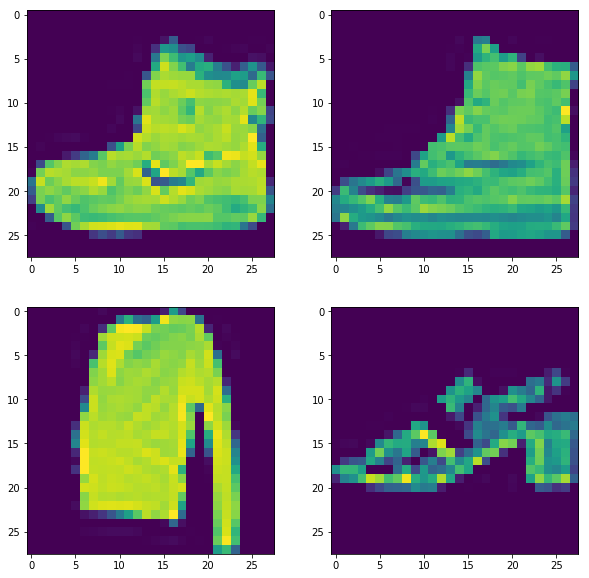

In [10]:
f = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 2, 1)
ax.imshow(X_train[0].reshape([28, 28]))

ax = plt.subplot(2, 2, 2)
i = np.random.randint(0, X_train.shape[0], 1)
ax.imshow(X_train[i].reshape([28, 28]))

ax = plt.subplot(2, 2, 3)
i = np.random.randint(0, X_train.shape[0], 1)
ax.imshow(X_train[i].reshape([28, 28]))

ax = plt.subplot(2, 2, 4)
i = np.random.randint(0, X_train.shape[0], 1)
ax.imshow(X_train[i].reshape([28, 28]))

### Задание:
Будем решать задачу классификации на 10 классов. Каждый класс соответствует одному из типов одежды. Исходная размерность признакового пространства: `784`, каждый пиксель является признаком. Будем снижать размерность признакового пространства с помощью метода главных компонент (`PCA`). Ваша задача оценить качество решенения задачи классификации по метрике `accuracy` в зависимости от числа главных компонент. Также оцените дисперсию функции качества в зависимости от числа главных компонент.

Нарисуйте график зависимости функции качества и ее дисперсии от числа главных компонент.

In [11]:
pca = PCA(n_components=3)
used_indices = np.random.choice(
    np.arange(X_train.shape[0]), 10000, replace=False)
X_train_lowdim = pca.fit_transform(X_train[used_indices].reshape([-1, 784]))
lr = LogisticRegression()
lr.fit(X_train_lowdim, y_train[used_indices])
accuracy_score(y_test, lr.predict(pca.transform(X_test.reshape([-1, 784]))))

0.58389999999999997

Используйте следующую сетку числа главных компонент: `[3, 5, 7, 12, 18, 25, 33, 40, 48, 55]`. Для ускорения сходимости можете семплировать подвыборки из `X_train`. 

In [13]:
# Your code here

#pca_steps = [3, 5, 7, 12, 18, 25, 33, 40, 48, 55]
pca_steps = np.arange(2, 80, 3)
n_repeat = 10

results = []
for pca_step in tqdm(pca_steps):

    result_step = []
    for i in range(n_repeat):

        pca = PCA(n_components=pca_step)
        used_indices = np.random.choice(
            np.arange(X_train.shape[0]), 10000, replace=False)
        X_train_reduced = pca.fit_transform(
            X_train[used_indices].reshape([-1, 784]))

        lr = LogisticRegression()
        lr.fit(X_train_reduced, y_train[used_indices])

        acc = accuracy_score(y_test, lr.predict(
            pca.transform(X_test.reshape([-1, 784]))))
        result_step.append(acc)
    results.append(result_step)
    
results = np.array(results)

In [31]:
plt.style.use('ggplot')
sns.set(font_scale=2)


def plot_results(results, steps, figsize=(10, 16)):

    means = results.mean(axis=1)
    stds = results.std(axis=1)

    f, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].plot(steps, means, '-', ms=10)
    ax[0].fill_between(steps, means - stds, means + stds, alpha=0.2)

    ax[0].set_xlabel('Number of PCA componens')
    ax[0].set_ylabel('Accuracy score')

    ax[1].plot(steps, stds**2)
    ax[1].set_xlabel('Number of PCA componens')
    ax[1].set_ylabel('Variance score')

    plt.ticklabel_format(axis='y', style='sci', scilimits=(1, 3))
    plt.show()

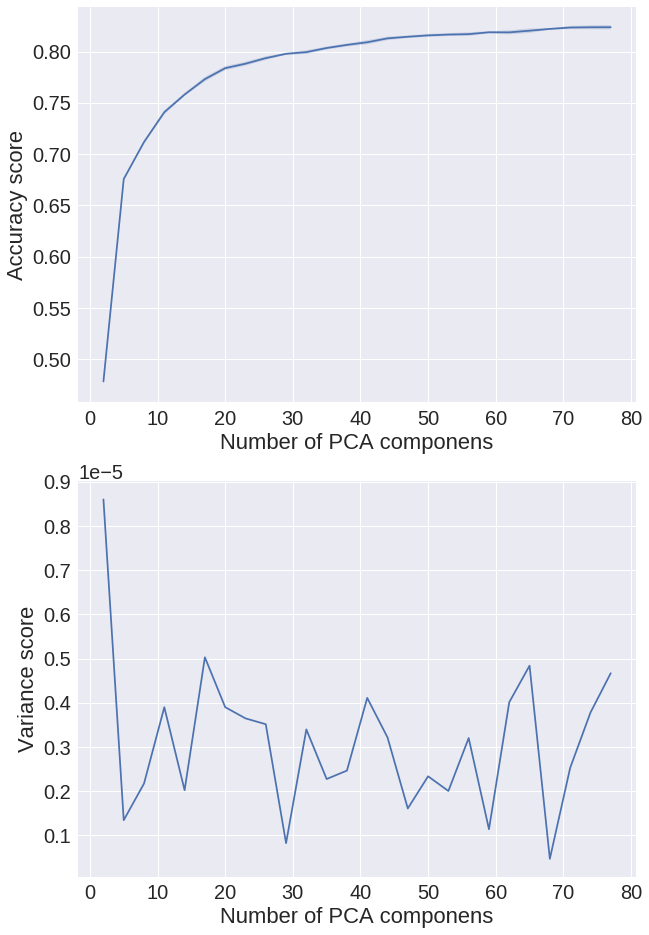

In [32]:
plot_results(results, pca_steps)

### Вывод:
Для получения столь же хорошего accuracy как на всех данных, мы можем снизить размерность данных до ~40 компонент. Дисперсия функции качества одинакого мала при снижении размерности до любого числа компонент > 5